# Exploratory Data Analysis

## Data Load

In [1]:
#required imports for the data analysis
import sqlite3
import re
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.gridspec as gspec
import seaborn as sns
import sklearn.preprocessing as prep
import sklearn.covariance as cov
import sklearn.neighbors as neighb
import sklearn.decomposition as decomp
import statsmodels.api as statsm

In [2]:
#setup connection to the database

mypath=".\\data\\insurance.db"
conn=sqlite3.connect(mypath)
cursor=conn.cursor()

In [3]:
#Get information about tables from db
cursor.execute("SELECT sql FROM sqlite_master WHERE type='table';")
tables=pd.DataFrame(cursor.fetchall(), columns=[d[0] for d in cursor.description])

table_variables=[]
for i in tables.iloc[:,0]:
    table_variables.append([j.group().replace("\"", '') for j in re.finditer('\".*\"',i)])

table_variables

[['LOB',
  'index',
  'Customer Identity',
  'Premiums in LOB: Motor',
  'Premiums in LOB: Household',
  'Premiums in LOB: Health',
  'Premiums in LOB:  Life',
  'Premiums in LOB: Work Compensations'],
 ['Engage',
  'index',
  'Customer Identity',
  'First Policy´s Year',
  'Brithday Year',
  'Educational Degree',
  'Gross Monthly Salary',
  'Geographic Living Area',
  'Has Children (Y=1)',
  'Customer Monetary Value',
  'Claims Rate']]

## Data Assessment 

In [4]:
#Build Analytical Base Table (ABT)
abtquery="""SELECT e.'Customer Identity', e.'First Policy´s Year', e.'Brithday Year', e.'Educational Degree', 
            e.'Gross Monthly Salary', e.'Geographic Living Area', e.'Has Children (Y=1)', e.'Customer Monetary Value', 
            e.'Claims Rate', l.'Premiums in LOB: Motor', l.'Premiums in LOB: Household', l.'Premiums in LOB: Health', 
            l.'Premiums in LOB:  Life', l.'Premiums in LOB: Work Compensations'
            FROM LOB l, Engage e
            WHERE l.'Customer Identity'=e.'Customer Identity'"""
cursor.execute(abtquery)

#Variables alias
alias=["id","first_policy","birthday","education","salary","area","children","cmv","claims_r","motor","household","health","life","work_comp"]

df=pd.DataFrame(cursor.fetchall(), columns=alias)
conn.close()
df.head()

,id,first_policy,birthday,education,salary,area,children,cmv,claims_r,motor,household,health,life,work_comp
0,1,1985.0,1982.0,2 - High School,2177.0,1.0,1.0,380.97,0.39,375.85,79.45,146.36,47.01,16.89
1,2,1981.0,1995.0,2 - High School,677.0,4.0,1.0,-131.13,1.12,77.46,416.20,116.69,194.48,106.13
2,3,1991.0,1970.0,1 - Basic,2277.0,3.0,0.0,504.67,0.28,206.15,224.50,124.58,86.35,99.02
3,4,1990.0,1981.0,3 - BSc/MSc,1099.0,4.0,1.0,-16.99,0.99,182.48,43.35,311.17,35.34,28.34
4,5,1986.0,1973.0,3 - BSc/MSc,1763.0,4.0,1.0,35.23,0.90,338.62,47.80,182.59,18.78,41.45


In [5]:
#Dimension of the dataset
df.shape

(10296, 14)

In [6]:
#Data types of the variables
df.dtypes

id                int64
first_policy    float64
birthday        float64
education        object
salary          float64
area            float64
children        float64
cmv             float64
claims_r        float64
motor           float64
household       float64
health          float64
life            float64
work_comp       float64
dtype: object

In [7]:
#Check if first_policy, birthday and salary are integers
for i in [df.first_policy.fillna(0), df.birthday.fillna(0), df.salary.fillna(0)]: #control for nans
    print(all(i.apply(lambda x: x.is_integer())))#will return True if all values of each series is an integer

True
True
True


In [8]:
#Correcting some data types
#"first_policy":int, "birthday":int, "salary":int, can't be converted due to NAs
df=df.astype({"area": object, "children": object})

In [9]:
#Get summary statistics from df
df.iloc[:,1:].describe(include='all')

,first_policy,birthday,education,salary,area,children,cmv,claims_r,motor,household,health,life,work_comp
count,10266.000000,10279.000000,10279,10260.000000,10295.0,10275.0,10296.000000,10296.000000,10262.000000,10296.000000,10253.000000,10192.000000,10210.000000
unique,NaN,NaN,4,NaN,4.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,3 - BSc/MSc,NaN,4.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,4799,NaN,4145.0,7262.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1991.062634,1968.007783,NaN,2506.667057,NaN,NaN,177.892605,0.742772,300.470252,210.431192,171.580833,41.855782,41.277514
std,511.267913,19.709476,NaN,1157.449634,NaN,NaN,1945.811505,2.916964,211.914997,352.595984,296.405976,47.480632,51.513572
min,1974.000000,1028.000000,NaN,333.000000,NaN,NaN,-165680.420000,0.000000,-4.110000,-75.000000,-2.110000,-7.000000,-12.000000
25%,1980.000000,1953.000000,NaN,1706.000000,NaN,NaN,-9.440000,0.390000,190.590000,49.450000,111.800000,9.890000,10.670000
50%,1986.000000,1968.000000,NaN,2501.500000,NaN,NaN,186.870000,0.720000,298.610000,132.800000,162.810000,25.560000,25.670000
75%,1992.000000,1983.000000,NaN,3290.250000,NaN,NaN,399.777500,0.980000,408.300000,290.050000,219.820000,57.790000,56.790000


In [10]:
#More info about df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10296 entries, 0 to 10295
Data columns (total 14 columns):
id              10296 non-null int64
first_policy    10266 non-null float64
birthday        10279 non-null float64
education       10279 non-null object
salary          10260 non-null float64
area            10295 non-null object
children        10275 non-null object
cmv             10296 non-null float64
claims_r        10296 non-null float64
motor           10262 non-null float64
household       10296 non-null float64
health          10253 non-null float64
life            10192 non-null float64
work_comp       10210 non-null float64
dtypes: float64(10), int64(1), object(3)
memory usage: 1.1+ MB


In [11]:
#Check duplicates
any(df.duplicated())

False

In [12]:
#Number of missing values in each feature
df.isna().sum()

id                0
first_policy     30
birthday         17
education        17
salary           36
area              1
children         21
cmv               0
claims_r          0
motor            34
household         0
health           43
life            104
work_comp        86
dtype: int64

In [13]:
#Frequencies of number of missing values across rows
df.isna().apply(lambda x:sum(x), axis=1).value_counts().sort_index()

0    9987
1     256
2      38
3       3
4      12
dtype: int64

In [14]:
#Define metric and non-metric datasets
metric_df= df.loc[:,(df.columns=="id") | (np.array(df.dtypes=="float64"))]
non_metric_df= df.loc[:,(df.columns=="id") | (np.array(df.dtypes=="object"))]

Format graphic! put title and so on

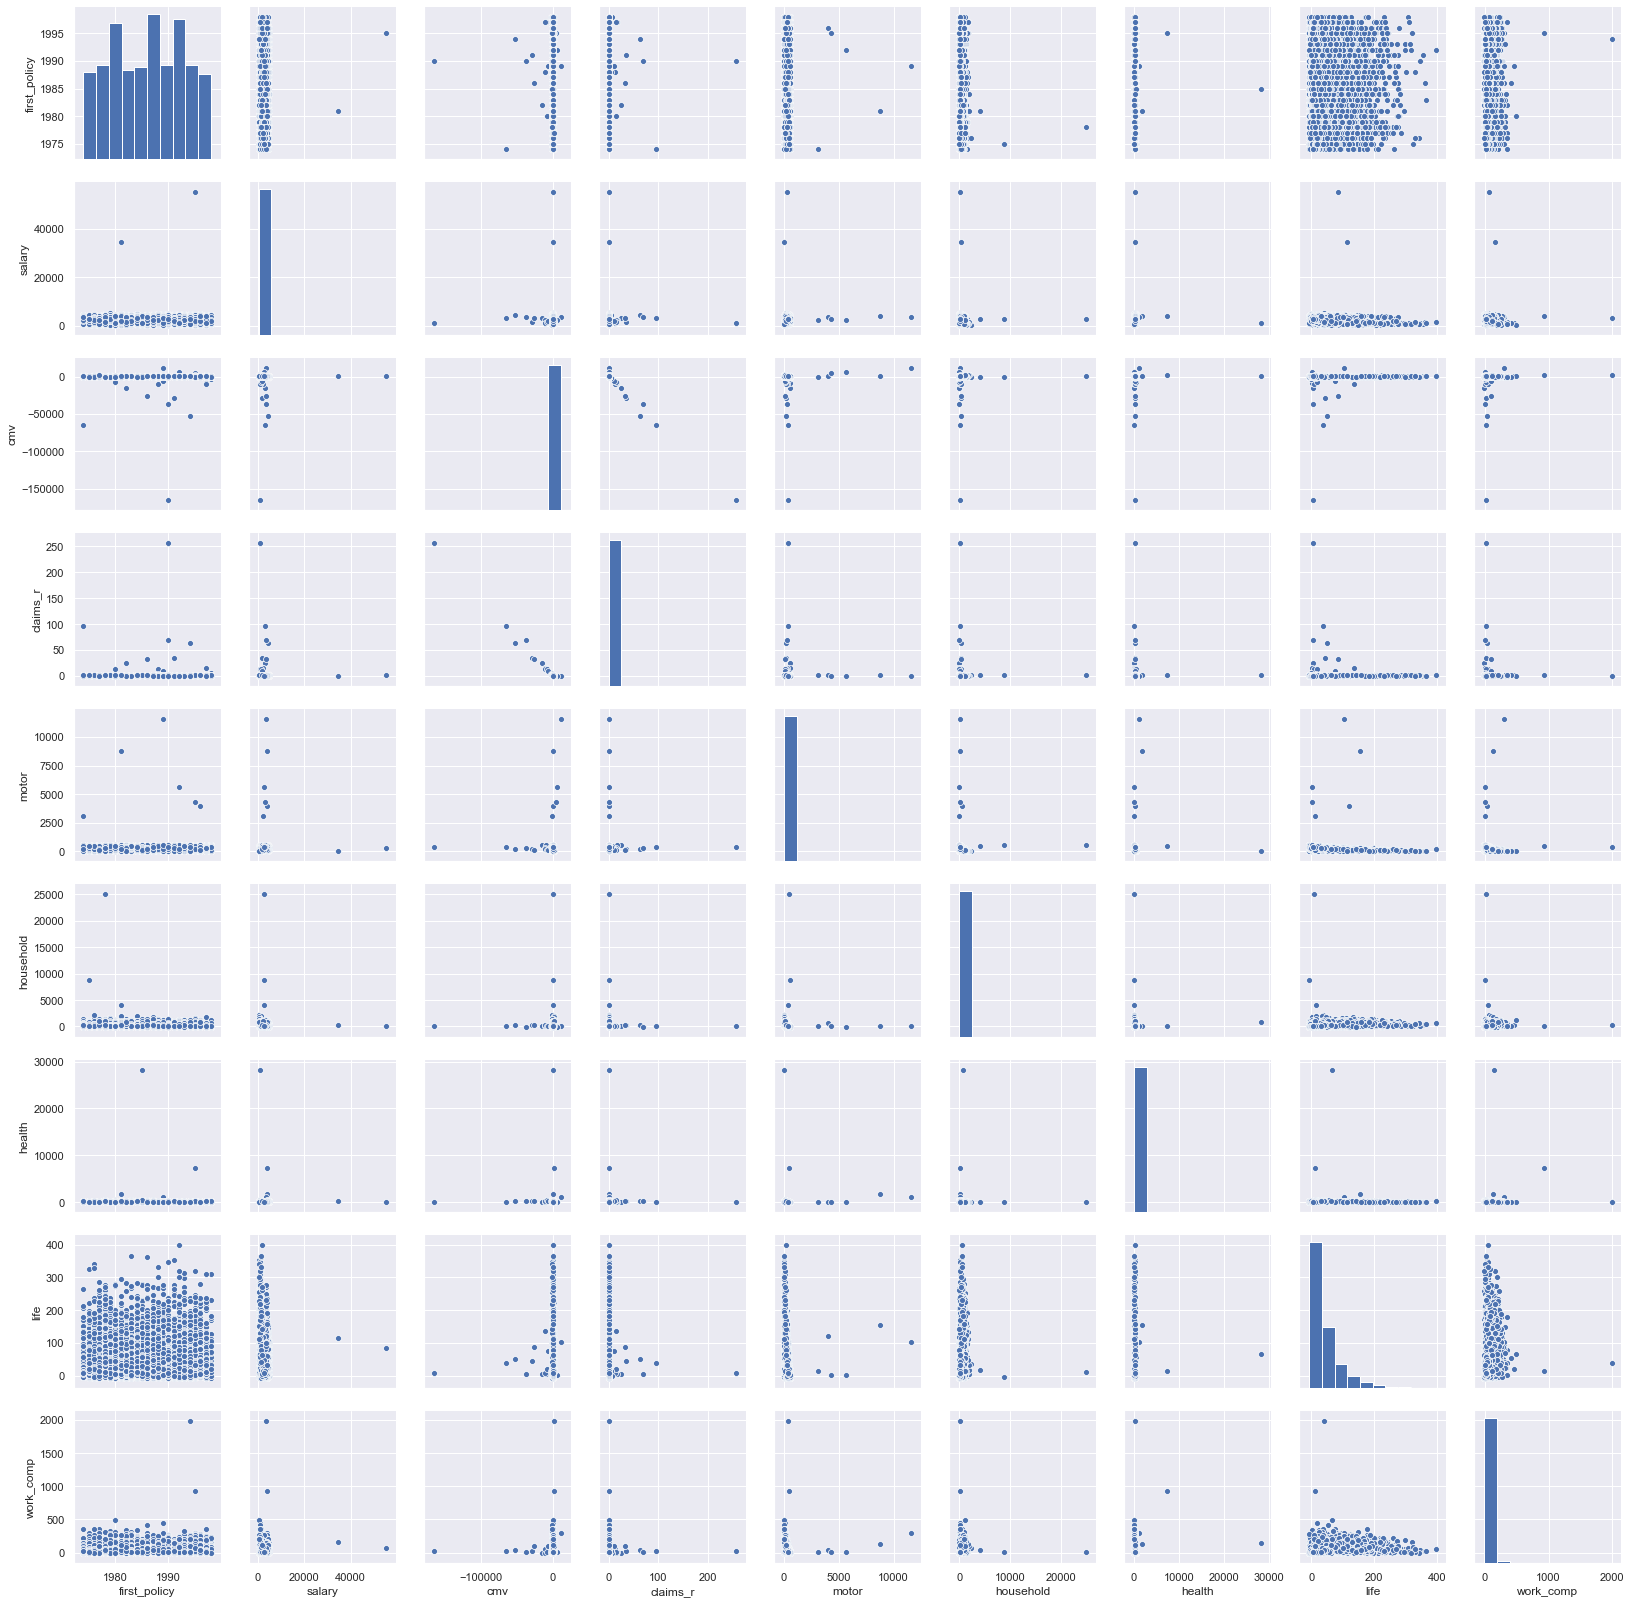

In [184]:
sns.set()
sns.pairplot(metric_df.drop("id",1).dropna()) #change number of bins in diagonal's scatter plots
plt.show()

Format graphic! Put title

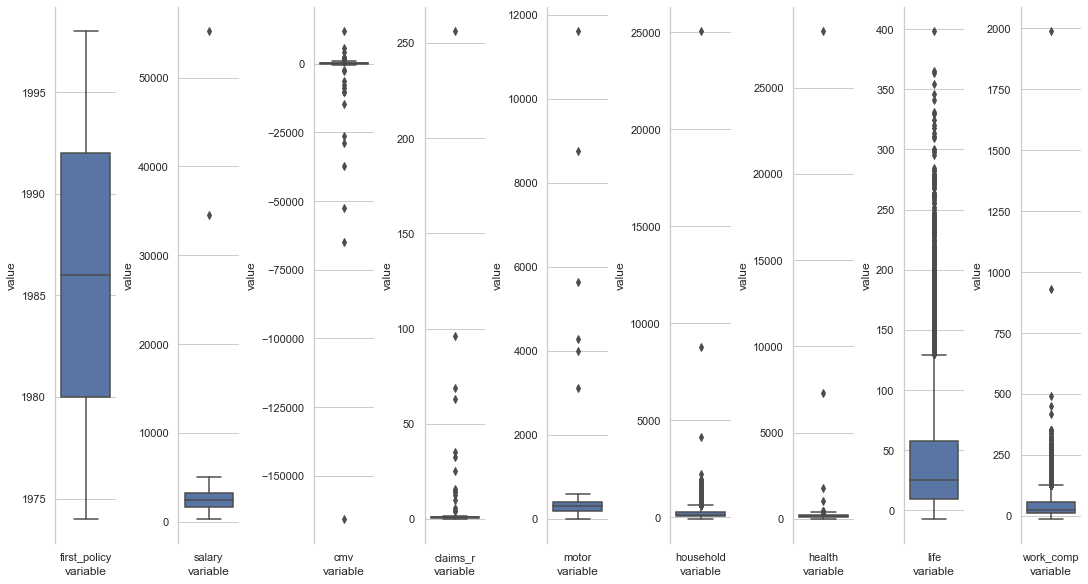

In [188]:
sns.set(style="whitegrid")

# Prepare dataframe layout
data=metric_df.melt("id")
plot_features= metric_df.drop("id",1).columns

#Prepare figure layout
fig= plt.figure(constrained_layout=True) #Create figure object
spec= gspec.GridSpec(ncols=len(plot_features), nrows=1, figure=fig) #Gridspec allows to define the grid structure which can  
                                                                    #then be populated through figure.add_subplot method
    
# Draw the violinplots and split the violins for easier comparison
for i, plot_f in enumerate(plot_features):
    ax= fig.add_subplot(spec[0,i])
    pdata= data.loc[data.loc[:,"variable"]==plot_f,:]
#     viol_df.loc[viol_df.loc[:,"variable"]==plot_f,:] #Selecting every variable-value pair for a specific metric variable
    graph= sns.boxplot(x="variable", y="value", data=pdata, ax=ax)

# Finalize the plot
sns.despine(bottom=True)
fig.set_size_inches(15, 8)

plt.show()

Format graphic add title and fix legend overlay

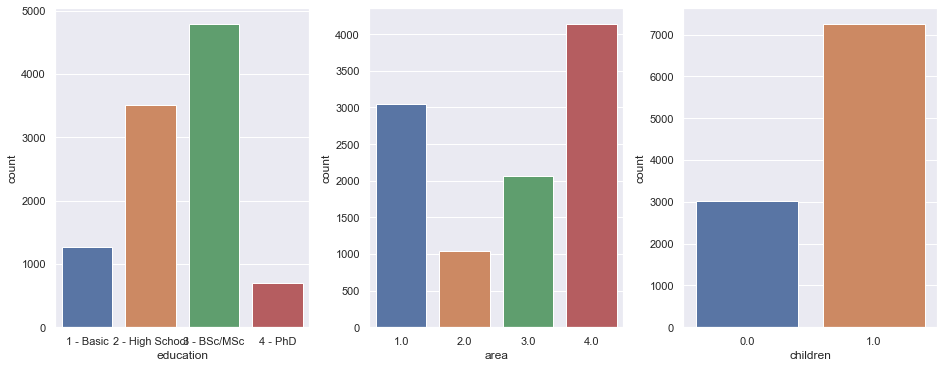

In [189]:
sns.set()
fig = plt.figure(constrained_layout=True, figsize=(13,5))
gs = fig.add_gridspec(1, 3)

# fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(gs[0, 0]) # 1st to the before last row, 2nd column to last
ax2 = fig.add_subplot(gs[0, 1]) # 1st to the before last row, 1st column
ax3 = fig.add_subplot(gs[0, 2]) # last row, every column

sns.countplot(x="education", data=non_metric_df, ax=ax1, order=["1 - Basic", "2 - High School", "3 - BSc/MSc", "4 - PhD"])
sns.countplot(x="area", data=non_metric_df, ax=ax2)
sns.countplot(x="children", data=non_metric_df, ax=ax3)

plt.show()

Format graphic, y label and title

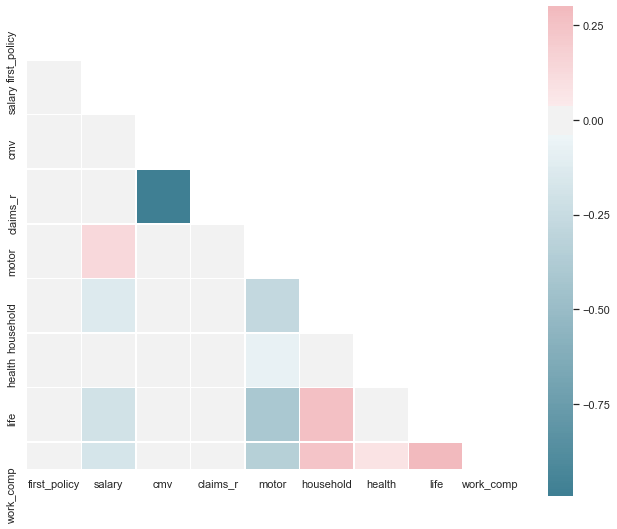

In [192]:
sns.set(style="white")

# Compute the correlation matrix
corr = metric_df.drop("id",1).corr() #Getting correlation of numerical variables

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool) #Return an array of zeros (Falses) with the same shape and type as a given array
mask[np.triu_indices_from(mask)] = True #The upper-triangle array is now composed by True values

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True) #Make a diverging palette between two HUSL colors. Return a matplotlib colormap object.

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5)

plt.show()

## Data cleaning

### Ideas
- see if mean of variables differs by area of living (t-test, pivot-table, ...)
- see the same for childs
- if cmv <0 and claims_r <1 then: bad customer (no pay); if cmv<0 and claims_r>1 then: prone to call insurance. Can we do thiss? claims_r is for the last 2 years and cmv is lifetime

### Coherence Checks
- first_policy >= birthday?
- some constraint regarding age and education (e.g. people with phd should at least have more than 25 yo)?
- minors have children/ salary/ etc?


In [16]:
df.loc[df.first_policy<df.birthday].head()

,id,first_policy,birthday,education,salary,area,children,cmv,claims_r,motor,household,health,life,work_comp
1,2,1981.0,1995.0,2 - High School,677.0,4,1,-131.13,1.12,77.46,416.20,116.69,194.48,106.13
13,14,1983.0,2000.0,1 - Basic,1043.0,3,1,-75.12,1.06,44.34,342.85,127.69,267.94,94.46
18,19,1981.0,1982.0,1 - Basic,1414.0,3,1,230.38,0.71,313.17,373.40,121.80,14.78,72.57
22,23,1976.0,1986.0,2 - High School,1495.0,1,1,-89.79,1.08,209.04,308.95,192.48,64.79,54.90
40,41,1994.0,1995.0,2 - High School,1177.0,4,1,121.36,0.84,52.01,455.65,135.47,146.36,148.03


It is possible to see above that some of our clients had their first_policy before they were even born.

In [17]:
df.loc[(df["birthday"]>1998) & (df["children"]==1)].head()

,id,first_policy,birthday,education,salary,area,children,cmv,claims_r,motor,household,health,life,work_comp
13,14,1983.0,2000.0,1 - Basic,1043.0,3,1,-75.12,1.06,44.34,342.85,127.69,267.94,94.46
186,187,1993.0,1999.0,1 - Basic,1247.0,2,1,-128.24,1.07,33.23,1026.30,82.57,75.68,212.15
397,398,1986.0,2000.0,1 - Basic,415.0,1,1,-218.48,1.22,52.01,348.40,49.01,193.48,225.82
480,481,1984.0,1999.0,1 - Basic,1581.0,4,1,866.27,0.21,30.34,683.45,98.13,71.68,249.16
526,527,1982.0,1999.0,1 - Basic,840.0,4,1,-23.54,1.00,132.69,165.60,137.36,129.69,164.14


It is possible to see above that some of our clients are minors and have children.

In [18]:
df.loc[df["birthday"]>1998].head()

,id,first_policy,birthday,education,salary,area,children,cmv,claims_r,motor,household,health,life,work_comp
13,14,1983.0,2000.0,1 - Basic,1043.0,3,1,-75.12,1.06,44.34,342.85,127.69,267.94,94.46
186,187,1993.0,1999.0,1 - Basic,1247.0,2,1,-128.24,1.07,33.23,1026.30,82.57,75.68,212.15
397,398,1986.0,2000.0,1 - Basic,415.0,1,1,-218.48,1.22,52.01,348.40,49.01,193.48,225.82
480,481,1984.0,1999.0,1 - Basic,1581.0,4,1,866.27,0.21,30.34,683.45,98.13,71.68,249.16
526,527,1982.0,1999.0,1 - Basic,840.0,4,1,-23.54,1.00,132.69,165.60,137.36,129.69,164.14


We can even see that clients born after 1998 are receviving salary. Furthermore, it is also possible to observe from the above tables that minors have insurance policies for household, cars, health, life and so on, which doesn't make a lot of sense either.

Given all this incoherencies caused by the birhtday variable and the feedback from our client that this variable contains some errors, we decided to drop this variable.

In [19]:
df=df.drop("birthday", axis=1)

### Outliers

We will divide the outlier dection procedure into **parametric** and **non-parametric** approaches.

We will use methods such as the interquantile range, standard deviation, mahalanobis distance (chi-square plots) and local outlier factor (LOF).

In order to apply some of the methods proposed we will need to map our variables to a **normal distribution**.

The end goal of this analysis is to end up with an outlier identificator column for each method and then decide which observations to exclude based on these.

**References:** https://scikit-learn.org/stable/modules/outlier_detection.html, https://scikit-learn.org/stable/auto_examples/covariance/plot_mahalanobis_distances.html#sphx-glr-auto-examples-covariance-plot-mahalanobis-distances-py, https://scikit-learn.org/stable/auto_examples/preprocessing/plot_map_data_to_normal.html, https://www.kaggle.com/kevinarvai/outlier-detection-practice-uni-multivariate

#### Apriori analysis

From the boxplots and scatter plots above we can visualize the presence of observations with values that are logically invalid and should be eliminated:
* first_policy values above 50000 (we are in 2019);

In [20]:
df=df.loc[(df["first_policy"]!=53784.0)] # we have to select the exact value otherwise we will eliminate nans

#Define metric and non-metric datasets
metric_df= df.loc[:,(df.columns=="id") | (np.array(df.dtypes=="float64"))]
non_metric_df= df.loc[:,(df.columns=="id") | (np.array(df.dtypes=="object"))]

#### Normal distribution transformations

There are three common approaches to make data more Gaussian-like:
* Box-Cox;
* Yeo-Johnson;
* Quantile transformations;

However, Box-Cox requires input data to be strictly positive, for that reason we will apply all the transformations whenever possible, and then compare the normality fit through the use of QQ-plots.

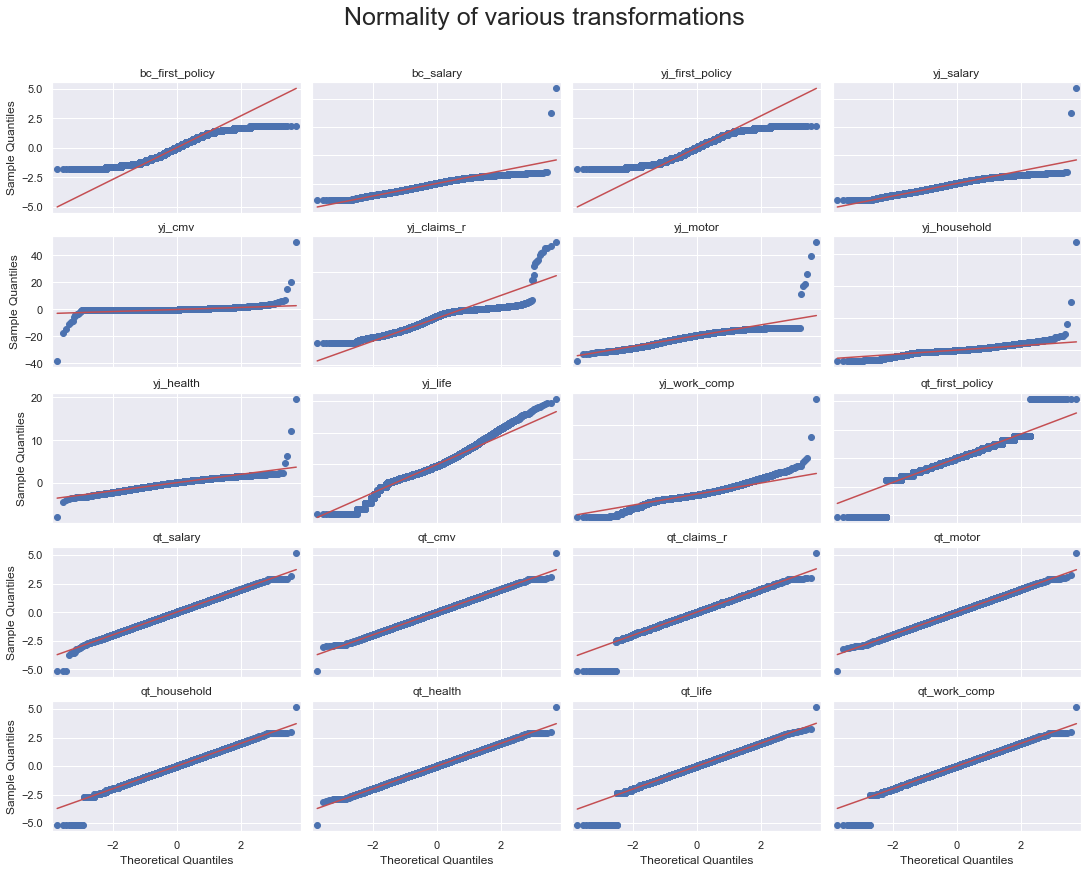

In [194]:
data = metric_df.set_index("id")
data.fillna(data.median(), inplace=True) #dealing with nans by replacing them for the median (this is not the final imputation)
mask = data.apply(lambda x: np.any(x<=0), axis=0)
labels = mask.index[mask==False].to_list() #getting stricly positive columns for BoxCox transformation

# Transformations
rng = np.random.RandomState(304)
bc = prep.PowerTransformer(method='box-cox')
yj = prep.PowerTransformer(method='yeo-johnson')
qt = prep.QuantileTransformer(n_quantiles=500, output_distribution='normal', random_state=rng)

# Perform power transforms and quantile transform
X_trans_bc = bc.fit_transform(data[labels])
X_trans_yj = yj.fit_transform(data)
X_trans_qt = qt.fit_transform(data)

# Merging
X_trans = np.concatenate((X_trans_bc, X_trans_yj, X_trans_qt), axis=1)

# Creating DataFrame
merge_labels=list(map(lambda x: "bc_" + x, labels))+list(map(lambda x: "yj_" + x, data.columns.to_list()))+list(map(lambda x: "qt_" + x, data.columns.to_list()))
trans_df=pd.DataFrame(X_trans, columns=merge_labels, index=data.index)

# Plot transformed data
sns.set()
fig, axes = plt.subplots(5,4, constrained_layout=True, figsize=(15,12))

fig.suptitle("Normality of various transformations\n", fontsize=25)

for col, ax in zip(trans_df.columns, axes.flatten()):
    x = trans_df.loc[:,col]
    statsm.qqplot(x, line="q", ax=ax)
#     sns.distplot(x, ax=ax, kde=False)
    ax.set_title(col)

# Just appear labels on outside axes
for ax in fig.get_axes():
    ax.label_outer()

plt.show()

The fit of the transformation to a Normal Distribution can be seen through the allignment of the points over the red line, which displays the behaviour or the points in case of perfect fit (the sample quantiles match the ones from a Normal distribution). As both the Quantile and Yeo-Johnson transformations provide gaussian-like distributions, we will use both to apply the parametric tests for outlier detection.

#### Univariate Outliers

In [24]:
transqt_df = trans_df.loc[:,[i for i in trans_df.columns.to_list() if "qt" in i]]
transyj_df = trans_df.loc[:,[i for i in trans_df.columns.to_list() if "yj" in i]]

In [25]:
def out_std(data, nstd=3.0, return_thresholds=False):
    """
    Return a boolean mask of outliers for a series using standard deviation, works column-wise.
    param nstd:
        Set number of standard deviations from the mean to consider an outlier
    :type nstd: ``float``
    param return_thresholds:
        True returns the lower and upper bounds, good for plotting.
        False returns the masked array 
    :type return_thresholds: ``bool``
    """
    data_mean, data_std = data.mean(), data.std()
    cut_off = data_std * nstd
    lower, upper = data_mean - cut_off, data_mean + cut_off
    if return_thresholds:
        return lower, upper
    else:
        return data.apply(lambda x: np.any((x<lower) | (x>upper)), 1)

def out_iqr(data, k=1.5, return_thresholds=False):
    """
    Return a boolean mask of outliers for a series using interquartile range, works column-wise.
    param k:
        some cutoff to multiply by the iqr
    :type k: ``float``
    param return_thresholds:
        True returns the lower and upper bounds, good for plotting.
        False returns the masked array 
    :type return_thresholds: ``bool``
    """
    # calculate interquartile range
    q25, q75 = np.percentile(data, 25, axis=0), np.percentile(data, 75, axis=0)
    iqr = q75 - q25
    # calculate the outlier cutoff
    cut_off = iqr * k
    lower, upper = q25 - cut_off, q75 + cut_off
    if return_thresholds:
        return lower, upper
    else: # identify outliers
        return data.apply(lambda x: np.any((x<lower) | (x>upper)), 1)

In [315]:
outlier_labels = pd.concat([out_std(transyj_df, 4), out_std(transqt_df, 4), out_iqr(transyj_df, 2.5), out_iqr(transqt_df, 2.5)], axis=1)
outlier_labels.columns = ["outyjstd","outqtstd","outyjiqr","outqtiqr"]

By using the functions out_std and out_iqr we obtain the potential outlier labels according to each transformation.
The value 1 classifies an observation as a potential outlier as long as at least one variable has an abnormal value. 

We define **abnormal values** has the ones outside the 2.5 x Interquantile Range (out_iqr) and the ones more than 3.5 Standard Deviations away from the mean (out_std).

#### Multivariate Normal Distribution
Even though our Univariate distributions are Normal-like, Multivariate Normality is not guaranteed as the later is a consequence to the former and not otherwise. This might cause some error in the application of techniques that rely on Multivariate Normal distributed data.

In practice however, "pathological data sets that are normal in lower dimensional representations, but nonnormal in higher dimensions, are not frequently encountered" (Johnson and Wichern 2007, pp. 177) which validates our decision to apply this type of techniques in the transformed data.

#### Multivariate Outliers

In [316]:
def out_mahalanobis(data, random, contamination=0.03):
    n = data.shape[0]
    df = data.shape[1]
    # Obtain mahalanobis distance of each observation to the center and then sort it
    ee_out = cov.EllipticEnvelope(contamination=contamination, random_state=random).fit(data)
    mahalan = ee_out.mahalanobis(data)
    # Obtain chi-square percentiles of each observations
    quantiles = stats.chi2.ppf(q=np.fromfunction(lambda x:(x-0.5)/n, (n,)), df=df)
    # Obtain labels
    labels = ee_out.predict(data)
    return mahalan, quantiles, labels

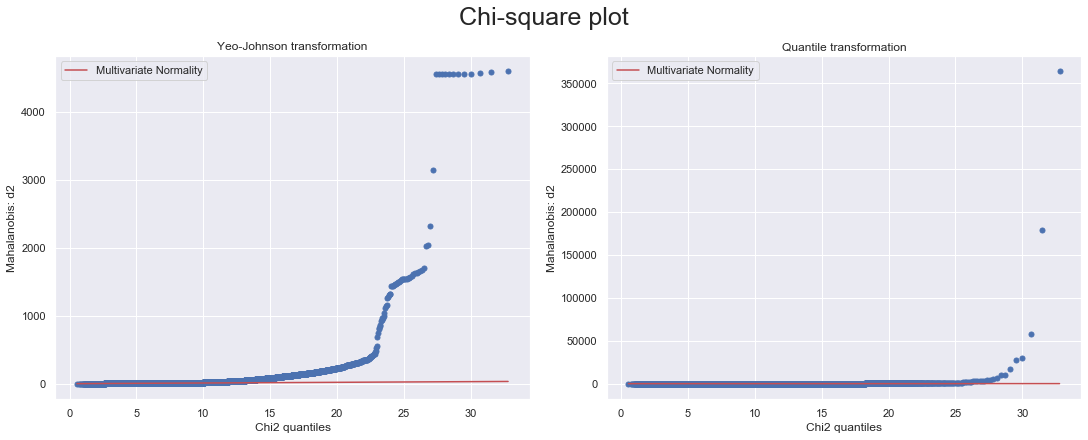

In [317]:
# Get x and y values for the Qui-square plots
sns.set()
mqt, qqt, lqt = out_mahalanobis(transqt_df, 0)
myj, qyj, lyj = out_mahalanobis(transyj_df, 0)
param = [[np.sort(mqt), qqt, "Yeo-Johnson transformation"], [np.sort(myj), qyj, "Quantile transformation"]]

# Chi-sq plot
fig, axes = plt.subplots(1, 2, constrained_layout=True, figsize=(15,6))
fig.suptitle("Chi-square plot", fontsize=25)

for ax, p in zip(axes.flatten(), param):
    ax.scatter(p[1], p[0], s=25)
    ax.plot(p[1], p[1], "-r", label="Multivariate Normality")
    ax.legend(loc="upper left")
    ax.set_title(p[2])
    ax.set_xlabel("Chi2 quantiles")
    ax.set_ylabel("Mahalanobis: d2")
    
plt.show()

From the above visualization, one can conclude that both the Yeo-Johnson and Quantile tranformations provide a slightly poor fit to a Multivariate Normal Distribution since d2 (that follows a Chi-square distribution in case of Multivariate Normality) doesn't match the Chi-square quantiles, expected in case of Multivariate Normality, i.e. the observations don't lie above the red line. (Johnson and Wichern 2007, pp. 177-192).

Even though our fitted distribution isn't the best, we can still conclude that there are certainly some potential multidimensional outliers since some observations are very distant from the center (high values of d2). For this reason, we will consider the outlier label provided by this method as well as the ones provided directly from the **Elliptic Envelop** method (this method was used to calculate the mahalanobis distance of every observation to the center with respect to a robust estimate of the covariance matrix).

Now we will apply a non-parametric approach that looks at the density in the input space to identify outliers. 

The Local Outlier Factor (LOF) method finds out isolated data points by estimating its density with respect to the surrounding neighborhood. More precisely, the k-nearest neighbors' distance is used to estimate the local density of an observation. By comparing the local density of an observation to the local densities of its neighbors, one can identify observations that have a substantially lower density than their neighbors. These will be classified as outliers.

In [318]:
# Since we will use the original data (non-parametric method) and it isn't standardized we'll first do this since variables have different measurment scales
std_data = prep.StandardScaler().fit_transform(data)
lof = neighb.LocalOutlierFactor(n_neighbors=50, contamination="auto")
outlof = lof.fit_predict(std_data)

GIVE TITLES TO EACH AXIS AND DESCRIBE PLOT

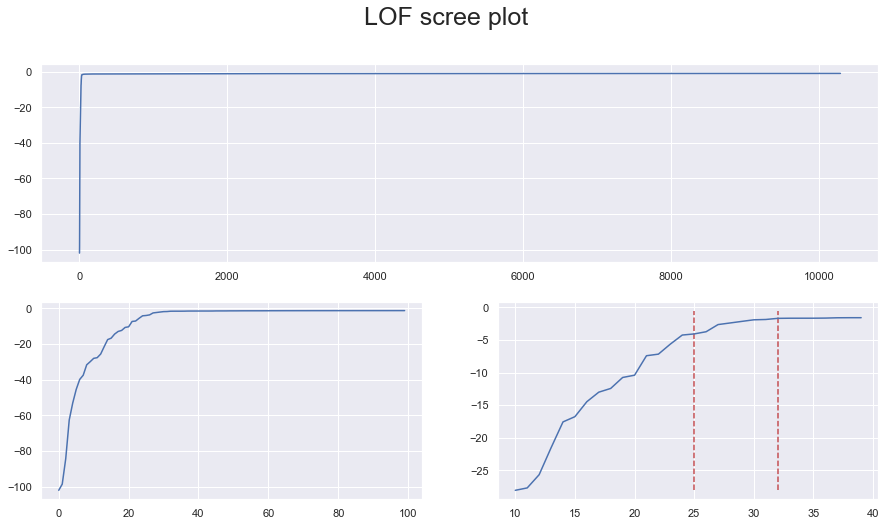

In [382]:
lof_scores = lof.fit(std_data).negative_outlier_factor_

sns.set()
#figure
fig=plt.figure(figsize=(15,8))
fig.suptitle("LOF scree plot", fontsize=25)

#axes
gs=gspec.GridSpec(2,2)
ax1=fig.add_subplot(gs[0,:]) # First row, first column
ax2=fig.add_subplot(gs[1,0]) # First row, second column
ax3=fig.add_subplot(gs[1,1]) # First row, all columns

#data
ax1.plot(np.sort(lof_scores))
ax2.plot(np.sort(lof_scores)[:100])
ax3.plot(np.sort(lof_scores)[10:40], data= np.arange(10, 40, 5))

#layout
ax3.set_xticklabels(list(map(str,range(5,45,5)))) #adjust ax3 x axis tick labels
ax3.vlines(x=[15,22], ymin=-28, ymax=-0.5, color="r", linestyles ="dashed")

plt.show()

USE THIS CUT-OFF POINT AS ANOTHER LABEL

Since the relative position of the points doesn't change with PCA (we are simply rotating the axes) then we will represent below our observations in a 3 dimensional space given by the 3 most important Principal Components so we can get an idea of where the potential ouliers identified by the LOF method are located.

Around 45% of the total variance is accounted by the 2 Principal Components



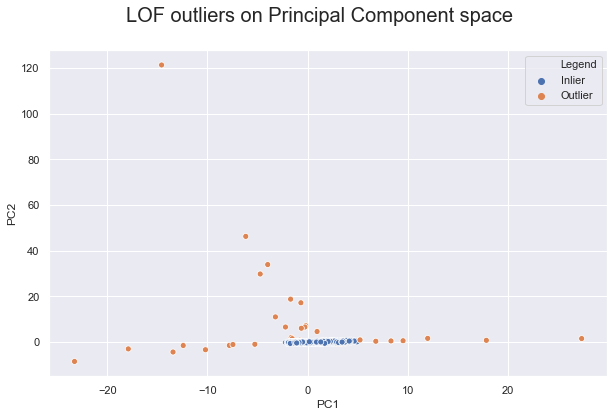

In [322]:
# PCA with standardized data since we are working with different measurment units (i.e. eigenvalue decomposition of the correlation matrix)
pca = decomp.PCA(n_components=2).fit(std_data)
print("Around {}% of the total variance is accounted by the 2 Principal Components\n".format(int(100*pca.explained_variance_ratio_.sum())))
scores = pca.transform(std_data) #representation of observations in the component space

# Visualizing the data and LOF potential outliers in the 3 Principal component space
label = np.where(outlof==-1, "Outlier", "Inlier")
vis2pc = pd.DataFrame(data=np.concatenate((scores,np.resize(label, (10295,1))), axis=1), columns=["PC1","PC2","Legend"])
vis2pc = vis2pc.astype(dict(zip(vis2pc.columns, [np.float64, np.float64, "object"])))

sns.set()
fig = plt.figure(figsize=(10,6))
fig.suptitle("LOF outliers on Principal Component space", fontsize=20)
sns.scatterplot(x="PC1", y="PC2", hue="Legend", data=vis2pc)
plt.show()

CONCLUSION!

In [323]:
outlier_labels = pd.concat([outlier_labels, pd.Series(data=(lyj==-1), index=data.index),
                            pd.Series(data=(lqt==-1), index=data.index),
                            pd.Series(data=data.index.isin(np.argsort(myj)[-100:]), index=data.index),
                            pd.Series(data=data.index.isin(np.argsort(mqt)[-100:]), index=data.index),
                            pd.Series(data=(outlof==-1), index=data.index)], axis=1)
outlier_labels.columns = ["outyjstd", "outqtstd", "outyjiqr", "outqtiqr", "outyjmhlnb", "outqtmhlnb", "outyjqqplt", "outqtqqplt", "outlof"]

In [324]:
pd.DataFrame(np.round(outlier_labels.mean(),3), columns=["Proportion of potential outliers for each method:"])

,Proportion of potential outliers for each method:
outyjstd,0.005
outqtstd,0.042
outyjiqr,0.024
outqtiqr,0.042
outyjmhlnb,0.030
outqtmhlnb,0.030
outyjqqplt,0.010
outqtqqplt,0.010
outlof,0.005


In [335]:
outlier_labels.drop(["outqtstd", "outqtiqr", "outqtmhlnb", "outqtqqplt"],axis=1).apply(lambda x: x.sum(), axis=1).value_counts()

0    9744
1     425
2      78
4      32
3      15
5       1
dtype: int64

In [376]:
test1 = outlier_labels.drop(["outqtstd", "outqtiqr", "outqtmhlnb", "outqtqqplt"],axis=1).apply(lambda x: x.sum(), axis=1)>2

UPDATE VALUES BELOW SINCE STD METHOD PASSED FROM 3.5 TO 4 STD

drop(["outqtstd", "outqtiqr"]) -> +2 ->104

drop(["outqtstd", "outqtiqr", "outqtmhlnb"]) -> +2 -> 68

drop(["outqtstd", "outqtiqr", "outqtmhlnb", "outqtqqplt"]) -> +2 -> 48 (perfect)

drop(["outqtstd", "outqtiqr", "outqtmhlnb", "outqtqqplt", "outyjmhlnb"]) -> +2 -> 39 (poorer than the rest)

just outlof -> 52 (poorer than the rest)

In [377]:
test1.value_counts()

False    10247
True        48
dtype: int64

In [298]:
test[test.argsort()[:27]]

array([-101.9726693 ,  -98.50380683,  -84.27628522,  -62.59677668,
        -53.1003422 ,  -45.476732  ,  -39.88356458,  -37.53487839,
        -31.69681082,  -29.95036673,  -28.0721897 ,  -27.70376257,
        -25.6766017 ,  -21.54548784,  -17.57613936,  -16.77160659,
        -14.47502686,  -13.01464816,  -12.4416618 ,  -10.7601414 ,
        -10.41006618,   -7.42157212,   -7.17954203,   -5.64003124,
         -4.24896451,   -4.07701543,   -3.74083793])

In [329]:
test3=pd.concat([pd.Series(data.index.isin(test.argsort()[:33]+1), index=data.index), outlier_labels["outyjstd"]], axis=1)

In [330]:
(~test3.apply(lambda x: np.any(x), axis=1)).value_counts()

True     10242
False       53
dtype: int64

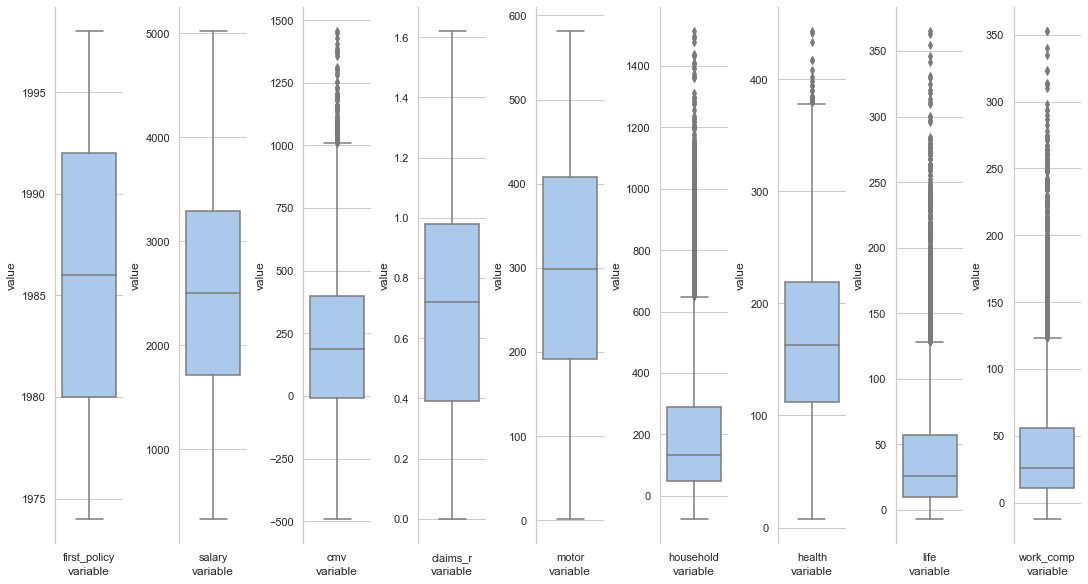

In [380]:
sns.set(style="whitegrid", palette="pastel", color_codes=True)

# Prepare dataframe layout
test2=data.loc[~test1].reset_index().melt("id")
plot_features= data.columns

#Prepare figure layout
fig= plt.figure(constrained_layout=True) #Create figure object
spec= gspec.GridSpec(ncols=len(plot_features), nrows=1, figure=fig) #Gridspec allows to define the grid structure which can  
                                                                    #then be populated through figure.add_subplot method
    
# Draw the violinplots and split the violins for easier comparison
for i, plot_f in enumerate(plot_features):
    ax= fig.add_subplot(spec[0,i])
    pdata= test2.loc[test2.loc[:,"variable"]==plot_f,:]
#     viol_df.loc[viol_df.loc[:,"variable"]==plot_f,:] #Selecting every variable-value pair for a specific metric variable
    graph= sns.boxplot(x="variable", y="value", data=pdata, ax=ax)

# Finalize the plot
sns.despine(bottom=True)
fig.set_size_inches(15, 8)

plt.show()

### Missing Values

# Dealing with Categorical Variables

In the particular case of education, since there's an inherent order in its scale, we will consider it as a metric variable.
* **We could use years of education instead, since the difference between basic and high school is different from the one between PhD and BSc/MSc**

In [90]:
df["educ_code"]=pd.to_numeric(df["education"].apply(lambda x: x[0] if x!=None else None))

0        2.0
1        2.0
2        1.0
3        3.0
4        3.0
        ... 
10291    4.0
10292    1.0
10293    3.0
10294    1.0
10295    4.0
Name: educ_code, Length: 10296, dtype: float64

## Feature Engineering
- Years as customer (YC)
- Years old (YO)
- YC/YO
- CMV/YC
- Total premiums
- Each premium/Total premiums
- Number of products= Number of non-zero premium columns

In [7]:
current_year=2016
years_customer= current_year-df.first_policy
age= current_year-df.birthday
years_customer_age= years_customer/age
cmv_years_customer= df.cmv/years_customer
t_premiums= df.loc[:,["motor","household","health","life","work_comp"]].apply(sum, axis=1)
perc_premiums= [df.loc[:,i]/t_premiums for i in ["motor","household","health","life","work_comp"]]

# Clustering

For mixed data types use k-prototypes? to merge metric and non-metric clustering. DONT'T USE FOR EXAMPLE K-MEANS WITH ONE-HOT ENCODED NON-METRIC VARIABLES (TEACHER DOESN'T LIKE IT AND IT DOESN'T MAKE SENSE TO CALCULATE DISTANCE BETWEEN NON-METRIC VARIABLES)